# Assignment 5


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* Declan Campbell
* Vanessa Roser

---

## Problem 1: Automatic Hubble (3pts)

Go back to Assignment 3. Get the Hubble data and take the GP error model from Problem 1.3 to solve the linear regression with correlated errors, but this time use `emcee` to get the posteriors.

Adopt non-informative priors, i.e. $p(b) \propto (1+b^2)^{-3/2}$ and $p(\sigma_y)\propto 1/\sigma_y$, and whatever you feel is appropriate for the priors of the parameter $\alpha$ and $\tau$ of the Matern kernel.

Plot the parameter contours with `corner` and make another plot that compares the data with samples of the posterior.

In [328]:
import numpy as np
import matplotlib.pyplot as plt

#%pip install jax
#%pip install -U emcee
#%pip install corner

import corner
from scipy import stats
import jax.numpy as jnp
#from jax import grad
from sklearn.metrics import pairwise_distances
import emcee

In [431]:


hubble = np.loadtxt('data.txt')

x = hubble[:,0].reshape(1,-1)[0]
y = hubble[:,1].reshape(1,-1)[0]

# start at the MLE
X = np.vander(x, N=2, increasing=True)
x_mle = np.linalg.inv(X.T @ X) @ X.T @ y # give slope and intercept a/b

b = .0015
sigma = 0.1
#for kernel
alpha = 1
tau = 100
#d = np.asarray(pairwise_distances(X))

params = np.asarray([sigma, alpha, tau, b])

def log_prior(params):
    sigma, alpha, tau, b = params
    if tau < 0 or alpha < 0 or sigma <= 0:
         return -np.inf
    lp = (-3/2)*np.log((1+b**2)) + np.log(1/sigma) + stats.gamma.logpdf(alpha, a=2, scale=1) + stats.gamma.logpdf(tau, scale=100, a=10) #np.log(1.0/(np.sqrt(2*np.pi)*sigma1))-0.5*(b-mu1)**2/sigma1**2
    return lp 

def get_kernel(X,alpha,tau):
    d = np.asarray(pairwise_distances(X))
    kern = alpha**2*(1 + (np.sqrt(3)*d)/tau) * np.exp((-np.sqrt(3)*d)/tau)   #or: Matern(length_scale=1, nu=1.5) ##UNSURE ABOUT PARAMETERS HERE 
    return kern

def get_K(X,sigma,alpha,tau):
    K = np.diag(np.repeat(sigma**2, len(X)))
    return K + get_kernel(X,alpha,tau)

def get_prob(params, X, Y):
    N = len(X)
    sigma, alpha, tau, b = params
    e = Y - b*X
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    K_new = get_K(X,sigma, alpha, tau)
    lkhd = (-0.5*(e.T) @ np.linalg.inv(K_new) @ e)[0][0] - 0.5*np.log(np.linalg.det(K_new))- (N/2)*(np.log(2*np.pi))
    return lkhd + lp 

# create a small ball around the MLE the initialize each walker 
nwalkers, ndim = 30, 4
pos = params + 1e-4 * np.random.randn(nwalkers, ndim)

# run emcee
Y = hubble[:,1].reshape(-1,1)
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_prob, args=(X, Y))
sampler.run_mcmc(pos, 5000, progress=False); #5000

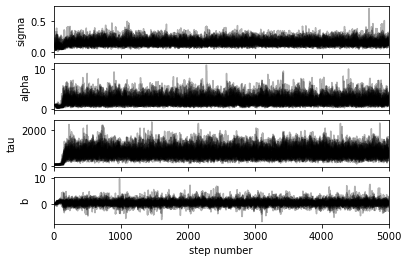

In [281]:
fig, axes = plt.subplots(ndim, sharex=True)
samples = sampler.get_chain()
labels = ['sigma', 'alpha', 'tau', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, rasterized=True)
    ax.set_xlim(0, 5000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

autocorr t: [55.33048257 54.43490831 72.28514023 43.33055304]


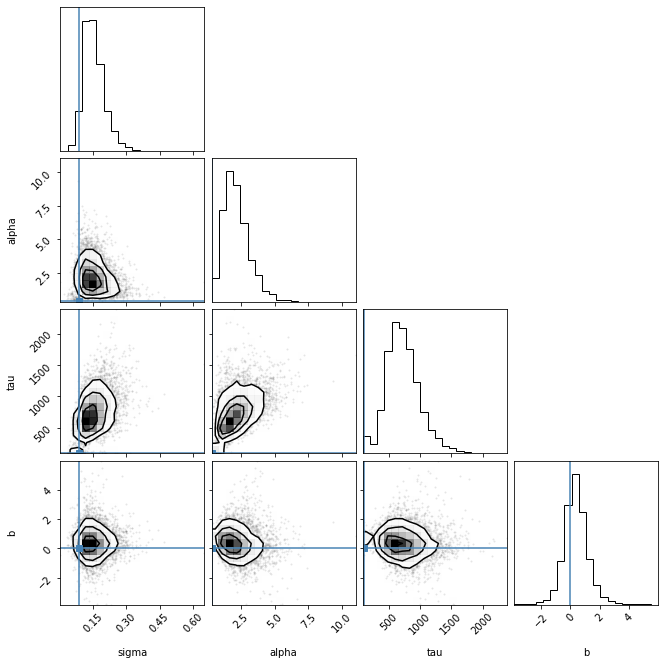

In [360]:
tau = sampler.get_autocorr_time()
print("autocorr t:",tau)
test_outs = [8.92850906e-02, 3.76681894e-01, 1.00292595e+02, 1.64466014e-03]
flat_samples = sampler.get_chain(discard=10, thin=int(np.mean(tau[0])/2), flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=test_outs)

[1.53657121e-01 2.17389929e+00 7.33292039e+02 3.77897823e-01]


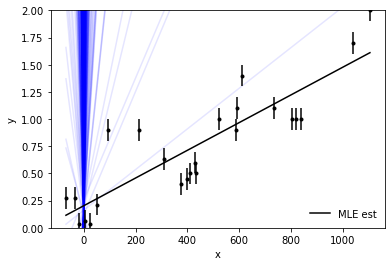

In [429]:
inds = np.random.randint(len(flat_samples), size=500)
print(np.mean(flat_samples,axis=0))
x = hubble[:,0].reshape(1,-1)[0]
y = hubble[:,1].reshape(1,-1)[0]

x0 = np.linspace(int(np.min(x)), int(np.max(x)), 100)

X = np.vander(x, N=2, increasing=True)
x_mle = np.linalg.inv(X.T @ X) @ X.T @ y # give slope and intercept a/b
#labels = ['sigma', 'alpha', 'tau', 'b']
for ind in inds:
    sample = flat_samples[ind]
    plt.ylim(0,2)
    plt.plot(x0, sample[0] + x0 * sample[3], 'b', alpha=0.1) #I wish for the sweet release of death

plt.errorbar(x, y, yerr=sigma, fmt=".k", capsize=0)
plt.plot(x0, x_mle[0] + x0 * x_mle[1], "k", label="MLE est")
plt.legend(frameon=False)
plt.ylim(0,2)
plt.xlabel("x")
plt.ylabel("y");

## Problem 2: HMC for Hierarchical Regression (7pts)

Implement the hierarchical linear regression model for math scores vs socio-econonic status (SES) from 100 schools we discussed in the lecture. But instead of the complicated Gibbs sampling sequence with its full conditionals, compute posteriors with HMC/NUTS.

## Problem 2.1 (3pts):

Get the data from the Hoff 2009 book [here](https://github.com/probml/pmtk3/blob/master/data/mathDataHoff.csv).
Treat each school independently and perform linear regression (with an unknown error) of math score as function of SES. Specifically, implement this model in `numpyro`:

\begin{align}
\mu &\sim \mathcal{N}(\mu_0, V_0)\\
\Sigma &\sim \mathrm{IW} (\eta_0, S_0^{-1})\\
w_j&\sim\mathcal{N}(\mu,\Sigma)\\
\sigma^2 &\sim \mathrm{IG} (\tfrac{1}{2}\nu_0, \tfrac{1}{2}\nu_0 \sigma_0^2)\\
e_{ij}&\sim\mathcal{N}(0, \sigma^2)
\end{align}

Take the mean of the posterior samples for the per-school linear regression weights and make a plot of these mean posterior predictions (see panel a) of Murphy Fig. 24.4). Store the posterior means of $w_j$ and $\sigma_j$ for every school for Problem 2.3.

**Hints**: 

* Pick reasonable values for the hyper-parameters $\mu_0, V_0,\dots$. A good method is to plot the resulting parameter distributions and compare them to the data. They should be wide enough to not overly influence the inference.
* The inverse Wishart distribution is not available in NumPyro yet. For univariate cases, it is identical to the inverse Gamma distribution. For the $2\times 2$ covariance $\Sigma$, assume independence of the slope and the intercept variances. Thus, sample two independent RVs from the inverse Gamma and treat them like a diagonal matrix covariance matrix. 
*
import jax.numpy as np
import numpy as onp
```

In [390]:
sample[3]

0.14046970690346872

In [324]:
#%pip install numpyro
import numpyro as npr
import jax.numpy as np
from jax import random
import numpy as onp
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [326]:
data = onp.genfromtxt('Hoffdata.csv',delimiter=',')

x = data[1:,2].reshape(1,-1)[0]
y = data[1:,3].reshape(1,-1)[0]

def linear_model(x, y=None, yerr=sigma):
    mu_init = 0
    V_init = 0
    a = npr.sample('a', dist.Uniform(-0.5, 0.5))
    b = npr.sample('b', dist.Uniform(0., 10))
    y_ = a + b*x
    sigma = npr.sample("sigma", dist.Normal(1.0)) #AAAA idk how to set up the error
    # notice that we clamp the outcome of this sampling to the observation y 
    npr.sample('obs', dist.Normal(y_, sigma), obs=y)


#______________________
def example_model(x, y, yerr=None):
    a = npr.sample('a', dist.Uniform(-0.5, 0.5))
    b = npr.sample('b', dist.Uniform(0., 10))
    y_ = a + b*x
    # notice that we clamp the outcome of this sampling to the observation y 
    npr.sample('obs', dist.Normal(y_, yerr), obs=y)
#______________________

# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# run HMC with NUTS
kernel = NUTS(linear_model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, x=x, y=y, yerr=0.1)
mcmc.print_summary()
#_______________________________________

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1142.51it/s, 3 steps of size 6.54e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.49      0.02      0.49      0.46      0.50   2676.14      1.00
         b      3.37      0.82      3.37      2.09      4.79   2440.98      1.00
     sigma     37.44      0.38     37.43     36.83     38.11   2588.44      1.00

Number of divergences: 0


### Problem 2.2 (3pts):

Now implement the full hierarchical scheme for the school regression coefficient $w_j$ we introduced in the lecture. Use the same hyperprior parameterization you used in 2.1. In other words, the only thing that changes is the linear model now predicts the values for the entire data set. 

Make a corner plot of the posterior for the set of hyperparameters $(\mu, \Sigma, \sigma)$. In another plot, show the linear regression from the mean posterior prediction for every school. Store the posterior means of $w_j$ for every school and of the global $\sigma$ for Problem 2.3.

**Hint:** `numpyro.plate` could be useful. 

In [ ]:

params = jnp.asarray([mu, cov, w, sigma, err])

def model(x, y)
    mu = npr.sample('mu', dist.Normal(mu_init, V_init))
    cov = #I want to die eta/S = slope intercept?
    sigma = jnp.sqrt(npr.sample('sigma', dist.InverseGamma(0.5*small_v_init, 0.5*small_v_init*sigma_init)))

    with numpyro.plate("plate_i", len(x)): #oh jesus
        w = npr.sample('w', dist.Normal(mu, cov))
        err = npr.sample('w', dist.Normal(0, sigma**2))

    #X is the row of the Vandermonde matrix associated with the SES xij
    #w is a school-specific linear regression (intercept, slope) vector
    y_ = X*w + err
    npr.sample('obs', dist.Normal(y_, sigma), obs=y)


# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# run HMC with NUTS
kernel = NUTS(linear_model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000)
mcmc.run(rng_key_, x=x, y=y, yerr=0.1)
mcmc.print_summary()

### Problem 2.3 (1pt):

Make a [quiver plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) with the coordinates $(w_{j,0}, \sigma_j)$ from 2.1 as starting points and $(w_{j,0},\sigma)$ from 2.2 as end points (one arrow per school). Do the same with $w_{j,1}$ instead of $w_{j,0}$. Color-code each arrow with the number of students in each school. Interpret the result. 